In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes 
from IPython.display import display, HTML
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
import numpy as np
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
path = 'E:\\unist\\winter\\lpoint\\'

In [3]:
df = pd.read_csv(path+'data\\Demo_area.csv')

In [48]:
demo = pd.read_table(path+'data\\고객DEMO.txt', delimiter=',', engine='python')
shop = pd.read_table(path+'data\\쇼핑업종 상품구매.txt', delimiter=',', engine='python')
category = pd.read_table(path+'data\\쇼핑업종 상품분류.txt', delimiter=',', engine='python', encoding='utf-8')
nonshop = pd.read_table(path+'data\\쇼핑외 업종 상품구매.txt', delimiter=',', engine='python')

In [6]:
print(len(demo))
demo.head()

20000


,ID,GENDER,AGE_PRD,HOM_PST_NO
0,1,1,60PRD,52.0
1,2,2,60PRD,80.0
2,3,2,60PRD,620.0
3,4,1,60PRD,120.0
4,5,1,60PRD,NaN


In [7]:
print(len(shop))
shop.head()

3641082


,ID,RCT_NO,BIZ_UNIT,PD_S_C,BR_C,DE_DT,DE_HR,BUY_AM,BUY_CT
0,4008,2108,A01,215,2,20150216,13,59600,2
1,6379,2109,A01,75,29,20150213,11,35000,1
2,6379,2109,A01,149,4,20150115,10,85000,1
3,8002,2110,A01,138,10,20151220,10,25000,1
4,8002,2110,A01,138,10,20151220,10,21000,1


In [9]:
print(len(category))
category.head()

3788


,BIZ_UNIT,PD_S_C,PD_S_NM,PD_M_NM,PD_H_NM
0,A04,341,단행본서적(직배),특수점서적,서적/음반
1,A04,1,삼각김밥,삼각김밥,미반
2,A04,2,The커진삼각김밥,삼각김밥,미반
3,A04,3,말이김밥,김밥,미반
4,A04,4,트레이김밥,김밥,미반


In [10]:
print(len(nonshop))
nonshop.head()

178659


,ID,BIZ_UNIT,CRYM,U_AM,U_CT
0,9544,D03,201511,14400,1
1,9544,C01,201510,18000,1
2,9544,D01,201508,9500,2
3,9544,D01,201507,4200,1
4,9544,D03,201505,3900,1


In [165]:
nonshop[(nonshop['BIZ_UNIT']=='D03') & (nonshop['ID']==15035)]

,ID,BIZ_UNIT,CRYM,U_AM,U_CT
759,15035,D03,201505,8600,1
760,15035,D03,201506,24500,3
763,15035,D03,201509,28500,2
764,15035,D03,201511,42000,4
766,15035,D03,201503,64500,5
767,15035,D03,201501,16200,2
769,15035,D03,201504,28500,3
770,15035,D03,201512,42800,5
775,15035,D03,201510,75700,5
776,15035,D03,201502,73200,5


In [78]:
temp = shop.drop_duplicates(['ID', 'RCT_NO', 'DE_DT', 'DE_HR'])
temp.ID.value_counts().describe()
#temp.to_csv(path+'data\\drop_rct.csv', index=False)

count    18550.000000
mean        65.165553
std         78.836196
min          1.000000
25%         11.000000
50%         38.000000
75%         92.000000
max       1192.000000
Name: ID, dtype: float64

In [79]:
count = pd.DataFrame(temp.ID.value_counts())
count.reset_index(inplace=True)
count.columns = ['ID', 'count']
count.head()

,ID,count
0,16742,1192
1,178,935
2,611,930
3,12178,919
4,11736,789


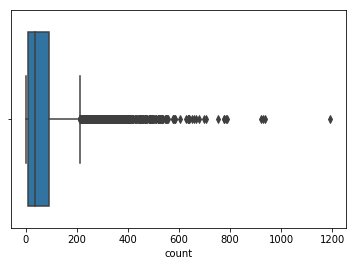

In [42]:
sns.boxplot(count['count'])

In [44]:
len(count[count['count']>210])

961

In [50]:
count[count['count']<=210]['count'].describe().astype(int)

count    17589
mean        52
std         51
min          1
25%         10
50%         34
75%         81
max        210
Name: count, dtype: int32

In [82]:
len(count[count['count']<10])

4277

In [3]:

scaler = MinMaxScaler()

## Customer Lifetime Value (CLV)

'Frequency' represents the number of repeat purchases the customer has made.   
'T' represents the age of the customer.  
'Recency' represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer's first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

In [4]:
clvd = shop.drop(['PD_S_C'], axis=1)
clvd['DT'] = clvd['DE_DT'].astype(str) + clvd['DE_HR'].astype(str)
clvd['DT'] = pd.to_datetime(clvd['DT'], format='%Y%m%d%H')
clvd.drop(['DE_DT', 'DE_HR'], axis=1, inplace=True)
clvd.head()

,ID,RCT_NO,BIZ_UNIT,BR_C,BUY_AM,BUY_CT,DT
0,4008,2108,A01,2,59600,2,2015-02-16 13:00:00
1,6379,2109,A01,29,35000,1,2015-02-13 11:00:00
2,6379,2109,A01,4,85000,1,2015-01-15 10:00:00
3,8002,2110,A01,10,25000,1,2015-12-20 10:00:00
4,8002,2110,A01,10,21000,1,2015-12-20 10:00:00


In [9]:
clvd = clvd.groupby(['ID', 'DT', 'BIZ_UNIT', 'RCT_NO', 'BR_C'])['BUY_AM'].sum().to_frame(name='AMT').reset_index()
clvd.head()

,ID,DT,BIZ_UNIT,RCT_NO,BR_C,AMT
0,1,2015-01-28 12:00:00,A01,100812,2,29800
1,1,2015-01-28 13:00:00,A01,37450,2,48000
2,1,2015-01-28 13:00:00,A01,110941,2,10000
3,1,2015-01-28 13:00:00,A01,157750,2,18000
4,1,2015-03-07 12:00:00,A01,149128,2,8900


In [63]:
# lifetimes provides a transaction log -> rfm util function
rfmw = lifetimes.utils.summary_data_from_transaction_data(
    clvd,
    'ID',
    'DT',
    monetary_value_col='AMT',
    freq='w'
)

rfmw.head()

,frequency,recency,T,monetary_value
ID,,,,
1,11.0,48.0,48.0,326375.454545
2,34.0,50.0,52.0,57693.882353
3,18.0,50.0,51.0,113882.444444
4,40.0,52.0,52.0,197791.400000
6,51.0,51.0,52.0,125467.137255


<lifetimes.BetaGeoFitter: fitted with 18550 subjects, a: 0.00, alpha: 2.00, b: 0.12, r: 0.88>


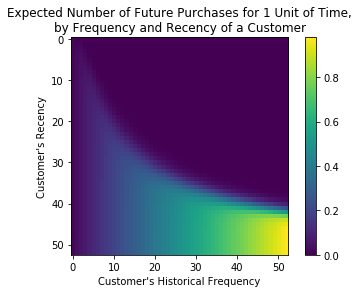

In [192]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix

bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(rfmw['frequency'], rfmw['recency'], rfmw['T'])
print(bgf)
plot_frequency_recency_matrix(bgf)

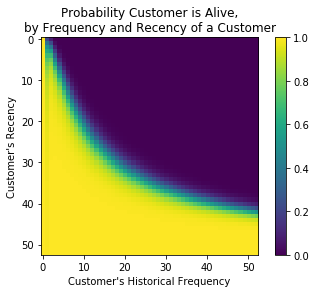

In [193]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [194]:
t = 1
rfmw['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, rfmw['frequency'], rfmw['recency'], rfmw['T'])
rfmw.sort_values(by='predicted_purchases').tail()

,frequency,recency,T,monetary_value,predicted_purchases
ID,,,,,
9217,52.0,52.0,52.0,1.571206e+05,0.97909
2603,52.0,52.0,52.0,1.956341e+05,0.97909
7405,52.0,52.0,52.0,8.678115e+04,0.97909
411,52.0,52.0,52.0,1.591108e+05,0.97909
6362,52.0,52.0,52.0,1.458716e+06,0.97909


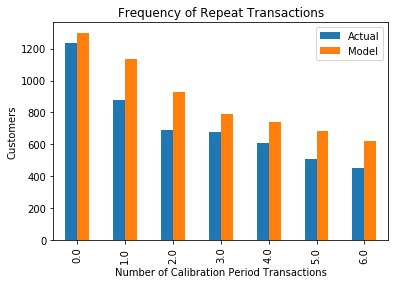

In [196]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [209]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(clvd, 'ID', 'DT',
                                        calibration_period_end='2015-09-30',
                                        observation_period_end='2015-12-31' )   

C:\ProgramData\Anaconda3\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:182: RuntimeWarning: invalid value encountered in log
  ln_hyp_term = np.log(hyp2f1(_a, _b, _c, _z))
C:\ProgramData\Anaconda3\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:186: RuntimeWarning: invalid value encountered in log
  ln_hyp_term_alt = np.log(hyp2f1(_c - _a, _c - _b, _c, _z)) + \


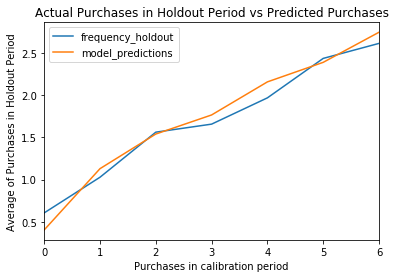

In [210]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [211]:
summary = summary_cal_holdout.copy()
duration_holdout = summary.iloc[0]['duration_holdout']
summary['model_predictions'] = summary.apply(lambda r: bgf.conditional_expected_number_of_purchases_up_to_time(duration_holdout, r['frequency_cal'], r['recency_cal'], r['T_cal']), axis=1)
import numpy as np
print('RMSE : ', np.sqrt(np.mean((summary['model_predictions']-summary['frequency_holdout'])**2)))

C:\ProgramData\Anaconda3\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:182: RuntimeWarning: invalid value encountered in log
  ln_hyp_term = np.log(hyp2f1(_a, _b, _c, _z))
C:\ProgramData\Anaconda3\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:186: RuntimeWarning: invalid value encountered in log
  ln_hyp_term_alt = np.log(hyp2f1(_c - _a, _c - _b, _c, _z)) + \


RMSE :  5.22987030583


#### CLV Value
Gamma-Gamma Model  
: he model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency.

In [64]:
# 상관관계 확인
ggd = rfmw[rfmw['monetary_value']>0]
ggd[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.160273
frequency,0.160273,1.000000


In [66]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(ggd['frequency'],
        ggd['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 17315 subjects, p: 0.42, q: 1.75, v: 390399.82>


In [11]:
# This method computes the conditional expectation of the average profit
# per transaction for a group of one or more customers.

expected_average_profit = ggf.conditional_expected_average_profit(
                            ggd['frequency'],
                            ggd['monetary_value'])
expected_average_profit.head()

ID
1    311078.206174
2     65705.591829
3    123272.094191
4    198633.193062
6    128593.735129
dtype: float64

In [67]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(ggd['frequency'], ggd['recency'], ggd['T'], )

clv = ggf.customer_lifetime_value(
        bgf, #the model to use to predict the number of future transactions
        ggd['frequency'],
        ggd['recency'],
        ggd['T'],
        ggd['monetary_value'],
        time=6, # month
        discount_rate=0.015 # monthly discount rate ~ 12.7% annually
        )
clv.head().astype(int)

ID
1    13087382
2     7126006
3     7556077
4    25149487
6    20546387
Name: clv, dtype: int32

In [70]:
clv.describe().astype(int)

count         17315
mean       16922883
std        39132056
min             274
25%         3472558
50%         7700404
75%        16951366
max      1853159875
Name: clv, dtype: int32

In [71]:
clv_df = clv.to_frame()
clv_df.reset_index(inplace=True)
clv_df.columns = ['ID', 'CLV']
clv_df['CLV'] = clv_df['CLV'].fillna(0)
clv_df['CLV'] = clv_df['CLV'].astype(int)
clv_df.head()

,ID,CLV
0,1,13087382
1,2,7126006
2,3,7556077
3,4,25149487
4,6,20546387


In [72]:
clv_df['CLV_std'] = scaler.fit_transform(np.log1p(clv_df[['CLV']]))

In [73]:
clv_df.head()

,ID,CLV,CLV_std
0,1,13087382,0.684992
1,2,7126006,0.646330
2,3,7556077,0.650057
3,4,25149487,0.726534
4,6,20546387,0.713677


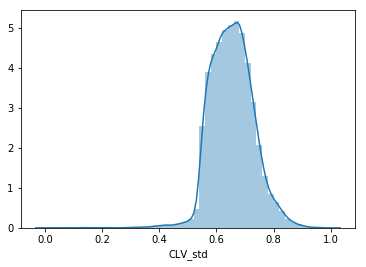

In [38]:
sns.distplot(clv_df['CLV_std'])

### 업종별 CLV

In [39]:
clvd.tail()

,ID,DT,BIZ_UNIT,RCT_NO,BR_C,AMT
1208837,19997,2015-12-30 11:00:00,A03,15417,152,35520
1208838,19998,2015-12-26 14:00:00,A02,280696,102,48500
1208839,19998,2015-12-26 17:00:00,A02,280685,102,95200
1208840,19999,2015-12-27 17:00:00,A01,47440,3,179000
1208841,20000,2015-12-31 17:00:00,A01,333029,16,69000


In [11]:
A01 = clvd[clvd['BIZ_UNIT']=='A01']
A02 = clvd[clvd['BIZ_UNIT']=='A02']
A03 = clvd[clvd['BIZ_UNIT']=='A03']
A04 = clvd[clvd['BIZ_UNIT']=='A04']
A05 = clvd[clvd['BIZ_UNIT']=='A05']

In [24]:
def rfm(df, freq='w', date='DT'):
    result = lifetimes.utils.summary_data_from_transaction_data(
        df,
        'ID',
        date,
        monetary_value_col='AMT',
        freq=freq
    )
    return result

In [7]:
def clv(df):
    df = df[df['monetary_value']>0]
    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(df['frequency'], df['recency'], df['T'])
    
    ggf = GammaGammaFitter(penalizer_coef = 0.001)
    ggf.fit(df['frequency'],
            df['monetary_value'])

    CLV = ggf.customer_lifetime_value(
        bgf, #the model to use to predict the number of future transactions
        df['frequency'],
        df['recency'],
        df['T'],
        df['monetary_value'],
        time=6, # month
        discount_rate=0.015 # monthly discount rate ~ 12.7% annually
        )

    clv_df = CLV.to_frame()
    clv_df.reset_index(inplace=True)
    clv_df.columns = ['ID', 'CLV']
    clv_df['CLV'] = clv_df['CLV'].fillna(0).astype(int)
    
    return clv_df

In [12]:
A01_RFM, A02_RFM, A03_RFM, A04_RFM, A05_RFM = rfm(A01), rfm(A02), rfm(A03), rfm(A04, 'd'), rfm(A05)

In [13]:
A01_CLV, A02_CLV, A03_CLV, A04_CLV, A05_CLV = clv(A01_RFM), clv(A02_RFM), clv(A03_RFM), clv(A04_RFM), clv(A05_RFM)

In [15]:
import functools
dfs = [A01_CLV, A02_CLV, A03_CLV, A04_CLV, A05_CLV]
CLV = functools.reduce(lambda left, right: pd.merge(left, right, on='ID', how='outer'), dfs).fillna(0)
CLV.columns = ['ID', 'A01_CLV', 'A02_CLV', 'A03_CLV', 'A04_CLV', 'A05_CLV']
CLV.sort_values(by='ID', inplace=True)
CLV.head()

,ID,A01_CLV,A02_CLV,A03_CLV,A04_CLV,A05_CLV
0,1,12999796.0,0.0,0.0,0.0,0.0
13869,2,0.0,5540848.0,0.0,0.0,0.0
1,3,5148149.0,1955926.0,101446.0,0.0,0.0
2,4,17799350.0,6939094.0,0.0,2780.0,0.0
3,6,1064900.0,16475721.0,2450834.0,63086.0,0.0


In [ ]:
scaler.fit_transform(np.log1p(CLV[['A01_CLV', 'A02_CLV', 'A03_CLV', 'A04_CLV', 'A05_CLV']]))

In [45]:
CLV[['A01_CLV', 'A02_CLV', 'A03_CLV', 'A04_CLV', 'A05_CLV']] = scaler.fit_transform(np.log1p(CLV[['A01_CLV', 'A02_CLV', 'A03_CLV', 'A04_CLV', 'A05_CLV']]))
CLV.to_csv(path+'data\\CLV_SHOP.csv', index=False)
CLV.head(100)

,ID,A01_CLV,A02_CLV,A03_CLV,A04_CLV,A05_CLV
0,1,0.864960,0.000000,0.000000,0.000000,0.000000
13869,2,0.000000,0.868199,0.000000,0.000000,0.000000
1,3,0.836275,0.833987,0.731518,0.000000,0.000000
2,4,0.874405,0.875357,0.000000,0.623664,0.000000
3,6,0.784351,0.902137,0.847850,0.772481,0.000000
4,7,0.851880,0.760447,0.000000,0.000000,0.000000
5,8,0.876689,0.852873,0.000000,0.000000,0.000000
6,9,0.891840,0.000000,0.811505,0.000000,0.000000
7,10,0.792430,0.000000,0.000000,0.000000,0.000000
8,11,0.858940,0.790472,0.000000,0.000000,0.000000


#### Non-shopping

In [26]:
ns_clvd = nonshop.groupby(['ID', 'BIZ_UNIT', 'CRYM'])['U_AM', 'U_CT'].sum().reset_index()
ns_clvd['CRYM'] = pd.to_datetime(ns_clvd['CRYM'], format='%Y%m')
ns_clvd['AMT'] = ns_clvd['U_AM']/ns_clvd['U_CT']
B01 = ns_clvd[ns_clvd['BIZ_UNIT']=='B01']
B02 = ns_clvd[ns_clvd['BIZ_UNIT']=='B02']
B03 = ns_clvd[ns_clvd['BIZ_UNIT']=='B03']
C01 = ns_clvd[ns_clvd['BIZ_UNIT']=='C01']
C02 = ns_clvd[ns_clvd['BIZ_UNIT']=='C02']
C03 = ns_clvd[ns_clvd['BIZ_UNIT']=='C03']
D01 = ns_clvd[ns_clvd['BIZ_UNIT']=='D01']
D02 = ns_clvd[ns_clvd['BIZ_UNIT']=='D02']
D03 = ns_clvd[ns_clvd['BIZ_UNIT']=='D03']

In [29]:
B01_RFM, B02_RFM, B03_RFM = rfm(B01, 'm', 'CRYM'), rfm(B02, 'm', 'CRYM'), rfm(B03, 'm', 'CRYM')
C01_RFM, C02_RFM, C03_RFM = rfm(C01, 'm', 'CRYM'), rfm(C02, 'm', 'CRYM'), rfm(C03, 'm', 'CRYM')
D01_RFM, D02_RFM, D03_RFM = rfm(D01, 'm', 'CRYM'), rfm(D02, 'm', 'CRYM'), rfm(D03, 'm', 'CRYM')

In [30]:
B01_CLV, B02_CLV, B03_CLV = clv(B01_RFM), clv(B02_RFM), clv(B03_RFM)
C01_CLV, C02_CLV, C03_CLV = clv(C01_RFM), clv(C02_RFM), clv(C03_RFM)
D01_CLV, D02_CLV, D03_CLV = clv(D01_RFM), clv(D02_RFM), clv(D03_RFM)

In [32]:
dfs = [B01_CLV, B02_CLV, B03_CLV, C01_CLV, C02_CLV, C03_CLV, D01_CLV, D02_CLV, D03_CLV]
CLV_nonshop = functools.reduce(lambda left, right: pd.merge(left, right, on='ID', how='outer'), dfs).fillna(0)
CLV_nonshop.columns = ['ID', 'B01_CLV', 'B02_CLV', 'B03_CLV', 'C01_CLV', 'C02_CLV', 'C03_CLV', 'D01_CLV', 'D02_CLV', 'D03_CLV']
CLV_nonshop.sort_values(by='ID', inplace=True)
CLV_nonshop.head()

,ID,B01_CLV,B02_CLV,B03_CLV,C01_CLV,C02_CLV,C03_CLV,D01_CLV,D02_CLV,D03_CLV
645,1,0.0,0.0,2757617.0,0.0,0.0,0.0,0.0,0.0,621335.0
13349,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,362705.0
13350,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,231061.0
646,4,0.0,0.0,1002756.0,667391.0,330951.0,0.0,659745.0,0.0,0.0
4313,6,0.0,0.0,0.0,332638.0,0.0,0.0,365562.0,0.0,365717.0


In [34]:
CLV_nonshop[['B01_CLV', 'B02_CLV', 'B03_CLV', 'C01_CLV', 'C02_CLV', 'C03_CLV', 'D01_CLV', 'D02_CLV', 'D03_CLV']] = scaler.fit_transform(np.log1p(CLV_nonshop[['B01_CLV', 'B02_CLV', 'B03_CLV', 'C01_CLV', 'C02_CLV', 'C03_CLV', 'D01_CLV', 'D02_CLV', 'D03_CLV']]))
CLV_nonshop.to_csv(path+'data\\CLV_NONSHOP.csv', index=False)
CLV_nonshop.head()

,ID,B01_CLV,B02_CLV,B03_CLV,C01_CLV,C02_CLV,C03_CLV,D01_CLV,D02_CLV,D03_CLV
645,1,0.0,0.0,0.808785,0.000000,0.000000,0.0,0.000000,0.0,0.810429
13349,2,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.777727
13350,3,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.750333
646,4,0.0,0.0,0.753614,0.779695,0.661546,0.0,0.800627,0.0,0.000000
4313,6,0.0,0.0,0.000000,0.739212,0.000000,0.0,0.765350,0.0,0.778230


#  
#  
## INDEX 개발

In [8]:
def calculate_rfm_nonshop(df):
    rfm = pd.DataFrame()
    
    temp = df.groupby(['ID'])['CRYM'].agg([('Min' , 'min'), ('Max', 'max')]).reset_index()
    r = (temp.Max.dt.to_period('M') - temp.Min.dt.to_period('M')).tolist()
    f = df.groupby(['ID'])['U_CT'].sum().reset_index()['U_CT'].tolist()
    m = df.groupby(['ID'])['U_AM'].sum().reset_index()['U_AM']/f
    
    rfm['ID'], rfm['recency'], rfm['frequency'], rfm['monetary_value'] = temp['ID'], r, f, m

    return rfm

def calculate_rfm_shop(df):
    rfm = pd.DataFrame()
    
    temp = df.groupby(['ID'])['DE_DT'].agg([('Min' , 'min'), ('Max', 'max')]).reset_index()
    r = (temp.Max.dt.to_period('M') - temp.Min.dt.to_period('M')).tolist()
    f = df.groupby(['ID']).size().reset_index(name='count')['count']
    m = df.groupby(['ID'])['AMT'].sum().reset_index()['AMT']/f
    
    rfm['ID'], rfm['recency'], rfm['frequency'], rfm['monetary_value'] = temp['ID'], r, f, m

    return rfm

def calculate_rfm(df1, df2):
    rfm = pd.DataFrame()
    
    shop_rfm = calculate_rfm_shop(df1)
    nonshop_rfm = calculate_rfm_nonshop(df2)
    temp =  pd.merge(shop_rfm, nonshop_rfm, on=['ID'], how='outer').sort_values('ID').fillna(0).reset_index(drop=True)
    
    rfm['ID'] = temp['ID']
    rfm['recency'] = temp[['recency_x', 'recency_y']].max(axis=1)
    rfm['frequency'] = temp['frequency_x'] + temp['frequency_y']
    rfm['monetary_value'] = ((temp['monetary_value_x']*temp['frequency_x'])
                            + (temp['monetary_value_y']*temp['frequency_y']))/rfm['frequency']
    
    return rfm

In [9]:
shop['DE_DT'] = pd.to_datetime(shop['DE_DT'], format='%Y%m%d')
nonshop['CRYM'] = pd.to_datetime(nonshop['CRYM'], format='%Y%m')
shop_merge = pd.merge(shop, category, on=['BIZ_UNIT', 'PD_S_C'], how='outer')

### COFFEE INDEX

In [19]:
## coffee index
coffee_list = category[category['PD_S_NM'].str.contains('커피')]['PD_S_NM'].tolist()

shop_cf = shop_merge[shop_merge['PD_S_NM'].isin(coffee_list)]
nonshop_cf = nonshop[nonshop['BIZ_UNIT']=='D03']

shop_cf = shop_cf.groupby(['ID', 'DE_DT', 'DE_HR', 'BIZ_UNIT', 'RCT_NO', 'BR_C'])['BUY_AM'].sum().to_frame(name='AMT').reset_index()
nonshop_cf = nonshop_cf.groupby(['ID', 'BIZ_UNIT', 'CRYM'])['U_AM', 'U_CT'].sum().reset_index()

coffee_rfm = calculate_rfm(shop_cf, nonshop_cf)
coffee_rfm['monetary_value'] = np.log1p(coffee_rfm['monetary_value'])
coffee_rfm['coffee_index'] = scaler.fit_transform(coffee_rfm[['recency']])*0.3 + scaler.fit_transform(coffee_rfm[['frequency']])*0.5 + scaler.fit_transform(coffee_rfm[['monetary_value']])*0.2
#coffee_rfm[['ID', 'coffee_index']].to_csv(path+'data\\coffee_index.csv', index=False)

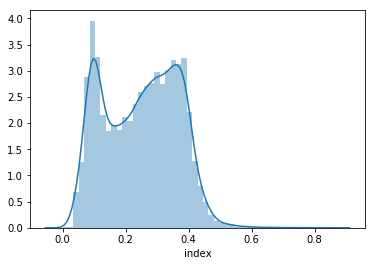

In [12]:
sns.distplot(coffee_rfm['index'])

### COSMETIC INDEX

In [20]:
cos = [303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 383, 854, 911, 912, 913, 914, 915, 975, 980, 981, 982, 983,984, 985, 987, 988, 989, 990, 992, 993, 999, 1000, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1047, 1357, 1358, 1359, 1360, 1579, 1580, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1628, 1629, 1630, 1631, 1633, 1632, 1635, 1636, 1637, 1639, 1640, 1641, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2530, 2745, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2801, 2906, 2978]
cosmetic_list = pd.DataFrame({'cosmetic_cat' : (category['PD_S_NM'].unique())}).iloc[cos]['cosmetic_cat'].tolist()

shop_cos = shop_merge[shop_merge['PD_S_NM'].isin(cosmetic_list)]

shop_cos = shop_cos.groupby(['ID', 'DE_DT', 'DE_HR', 'BIZ_UNIT', 'RCT_NO', 'BR_C'])['BUY_AM'].sum().to_frame(name='AMT').reset_index()

cosmetic_rfm = calculate_rfm_shop(shop_cos)
cosmetic_rfm['monetary_value'] = np.log1p(cosmetic_rfm['monetary_value'])
cosmetic_rfm['monetary_value'] = np.log1p(cosmetic_rfm['monetary_value'])
cosmetic_rfm['cosmetic_index'] = scaler.fit_transform(cosmetic_rfm[['recency']])*0.25 + scaler.fit_transform(cosmetic_rfm[['frequency']])*0.4 + scaler.fit_transform(cosmetic_rfm[['monetary_value']])*0.35
#cosmetic_rfm[['ID', 'cosmetic_index']].to_csv(path+'data\\cosmetic_index.csv', index=False)

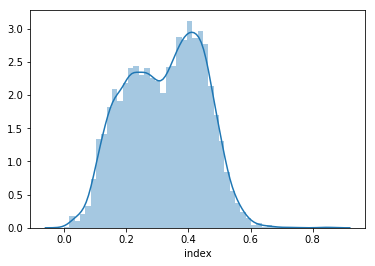

In [14]:
sns.distplot(cosmetic_rfm['index'])

### BABY INDEX

In [72]:
## baby index
baby_words = ['유아', '젖병', '매트', '목욕용장난감', '베이비', '토들러', '미취학', '발육기', '아기', '기저귀', '분유', '이유식', '카시트']
baby_list = category[category['PD_S_NM'].str.contains('|'.join(baby_words))]['PD_S_NM'].tolist()
drop_list = ['매트/훈증기', '복숭아기타', '카매트', '성인용기저귀', '전기매트', '패브릭욕실매트',
            '다용도매트', '싱크매트', '온라인매트', '프리미엄다용도매트', '프리미엄싱크매트', '매트']
baby_list = [a for a in baby_list if a not in drop_list]

shop_baby = shop_merge[shop_merge['PD_S_NM'].isin(baby_list)]

shop_baby = shop_baby.groupby(['ID', 'DE_DT', 'DE_HR', 'BIZ_UNIT', 'RCT_NO', 'BR_C'])['BUY_AM'].sum().to_frame(name='AMT').reset_index()

baby_rfm = calculate_rfm_shop(shop_baby)
baby_rfm['monetary_value'] = np.log1p(baby_rfm['monetary_value'])
baby_rfm['monetary_value'] = scaler.fit_transform(baby_rfm[['monetary_value']])
baby_rfm['baby_index'] = scaler.fit_transform((1-baby_rfm[['recency']]))*0.4 + scaler.fit_transform(baby_rfm[['frequency']])*0.3 + scaler.fit_transform(baby_rfm[['monetary_value']])*0.3
baby_rfm[['ID', 'baby_index']].to_csv(path+'data\\baby_index.csv', index=False)

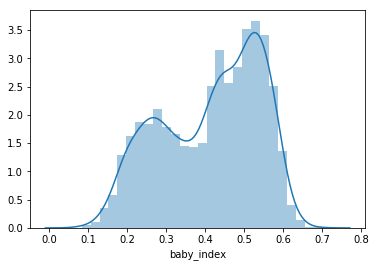

In [73]:
sns.distplot(baby_rfm['baby_index'])

#### INDEX MERGE

In [57]:
mv = pd.read_csv(path+'data\\mv_index.csv')
meal = pd.read_csv(path+'data\\meal_index.csv')
eatout = pd.read_csv(path+'data\\eatout_index.csv')
coffee = pd.read_csv(path+'data\\coffee_index.csv')
cosmetic = pd.read_csv(path+'data\\cosmetic_index.csv')
baby = pd.read_csv(path+'data\\baby_index.csv')

In [58]:
mv = mv.drop('Unnamed: 0', axis=1)
meal = meal.drop('Unnamed: 0', axis=1)
eatout = eatout.drop('Unnamed: 0', axis=1)

In [74]:
dfs = [demo, clv_df[['ID', 'CLV_std']], CLV, CLV_nonshop, cosmetic[['ID', 'cosmetic_index']], coffee[['ID', 'coffee_index']], baby[['ID', 'baby_index']], mv, meal, eatout]
result = functools.reduce(lambda left, right: pd.merge(left, right, on='ID', how='outer'), dfs).fillna(0)
result.to_excel(path+'\\data\\demo180120.xlsx', index=False)
result.head()

,ID,GENDER,AGE_PRD,HOM_PST_NO,CLV_std,A01_CLV,A02_CLV,A03_CLV,A04_CLV,A05_CLV,...,C03_CLV,D01_CLV,D02_CLV,D03_CLV,cosmetic_index,coffee_index,baby_index,MV_RFM,HM_RFM,EO_RFM
0,1,1,60PRD,52.0,0.684992,0.864960,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.810429,0.000000,0.195143,0.533341,0.114132,0.000000,0.000000
1,2,2,60PRD,80.0,0.646330,0.000000,0.868199,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.777727,0.000000,0.284426,0.436178,0.000000,0.000000,0.132227
2,3,2,60PRD,620.0,0.650057,0.836275,0.833987,0.731518,0.000000,0.0,...,0.0,0.000000,0.0,0.750333,0.000000,0.134193,0.000000,0.000000,0.000000,0.000000
3,4,1,60PRD,120.0,0.726534,0.874405,0.875357,0.000000,0.623664,0.0,...,0.0,0.800627,0.0,0.000000,0.406597,0.110400,0.000000,0.333758,0.305176,0.346951
4,5,1,60PRD,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [75]:
result.to_excel(path+'\\data\\demo_180120.xlsx', index=False)

#  
## APPENDIX

In [74]:
# lifetimes provides a transaction log -> rfm util function
rfm = lifetimes.utils.summary_data_from_transaction_data(
    clvd,
    'ID',
    'DE_DT',
    monetary_value_col='BUY_AM',
    observation_period_end=pd.to_datetime('2015-08-15'),
)

rfm.head()

,frequency,recency,T,monetary_value
ID,,,,
1,8.0,189.0,199.0,307516.250000
2,31.0,225.0,227.0,42931.677419
3,12.0,217.0,219.0,60700.416667
4,35.0,210.0,225.0,168091.028571
6,110.0,228.0,229.0,36850.309091


<lifetimes.BetaGeoFitter: fitted with 17760 subjects, a: 0.00, alpha: 7.81, b: 0.35, r: 0.89>


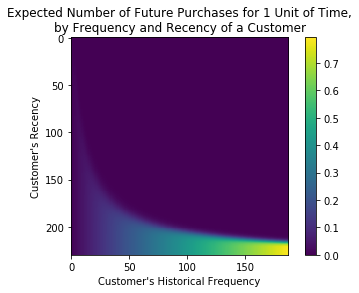

In [89]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix

bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])
print(bgf)
plot_frequency_recency_matrix(bgf)

<lifetimes.BetaGeoFitter: fitted with 17867 subjects, a: 0.00, alpha: 1.74, b: 0.00, r: 1.74>


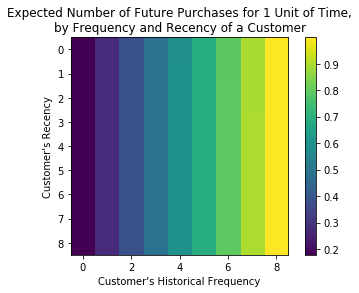

In [97]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(rfmm['frequency'], rfmm['recency'], rfmm['T'])
print(bgf)
plot_frequency_recency_matrix(bgf)

In [94]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head(10)

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00
5,0,0.00,38.86,0.00
6,7,29.43,38.86,73.74
7,1,5.00,38.86,11.77
8,0,0.00,38.86,0.00
9,2,35.71,38.86,25.55


In [3]:
df = pd.read_csv(path+'data\\demo_final_log.csv', encoding='cp949')

df['AGE_PRD'] = df['AGE_PRD'].str[0:2].astype(int)/100
df.loc[df['GENDER']=='Male', 'GENDER'] = 0
df.loc[df['GENDER']=='Female', 'GENDER'] = 1
#area_encoding = pd.get_dummies(df['Customer_Area'], drop_first=True)
#df = df.join(area_encoding)
#df.drop(['Customer_Area', 'BR_C'], axis=1, inplace=True)
df.drop(['BR_C'], axis=1, inplace=True)

df['item_type_num'] = scaler.fit_transform(np.log1p(df[['item_type_num']]))
df[['total_AM']] = scaler.fit_transform(np.log1p(df[['total_AM']]))
df[['mean_AM']] = scaler.fit_transform(np.log1p(df[['mean_AM']]))
df = df[df['count']>=10]
df['count'] = scaler.fit_transform(np.log1p(df[['mean_AM']]))

df.to_csv(path+'data\\demo_final_log.csv', index=False)
df.head()

NameError: name 'scaler' is not defined

In [22]:
df = pd.read_csv(path+'data\\id_shop_s_new2.csv', encoding='cp949')

In [23]:
df.head()

,ID,A01_5 ON THE GO,A01_ANDZ,A01_ARCHIV,A01_BON,A01_BYETTOL,A01_CJ팩토리샵,A01_DKNY,A01_EC(해외잡화),A01_el Bicar,...,A05_판초콜릿,A05_피스니스,A05_피트니스,A05_하드캔디,A05_핸드/풋케어,A05_향초,A05_헤어드라이어,A05_헤어미용,A05_헤어세팅기,A05_헤어에센스
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df.columns.tolist()

['ID',
 'GENDER',
 'AGE_PRD',
 'Customer_Area',
 'count',
 'dawn_rate',
 'morning_rate',
 'afternoon_rate',
 'evening_rate',
 'midnight_rate',
 'Weekend_rate',
 'A01_Weekend_rate',
 'A02_Weekend_rate',
 'A03_Weekend_rate',
 'A04_Weekend_rate',
 'A05_Weekend_rate',
 'item_type_num',
 'total_AM',
 'mean_AM',
 'sports_score',
 'travel_score',
 'goods_score',
 'A01_rate',
 'A02_rate',
 'A03_rate',
 'A04_rate',
 'A05_rate',
 'B01_rate',
 'B02_rate',
 'B03_rate',
 'C01_rate',
 'C02_rate',
 'C03_rate',
 'D01_rate',
 'D02_rate',
 'D03_rate',
 'A01_dawn_rate',
 'A01_morning_rate',
 'A01_afternoon_rate',
 'A01_evening_rate',
 'A01_midnight_rate',
 'A02_dawn_rate',
 'A02_morning_rate',
 'A02_afternoon_rate',
 'A02_evening_rate',
 'A02_midnight_rate',
 'A03_dawn_rate',
 'A03_morning_rate',
 'A03_afternoon_rate',
 'A03_evening_rate',
 'A03_midnight_rate',
 'A04_dawn_rate',
 'A04_morning_rate',
 'A04_afternoon_rate',
 'A04_evening_rate',
 'A04_midnight_rate',
 'A05_dawn_rate',
 'A05_morning_rate',
 

In [17]:
df.loc[:,['ID', 'A01_rate',
 'A02_rate',
 'A03_rate',
 'A04_rate',
 'A05_rate',
'B01_rate',
 'B02_rate',
 'B03_rate',

         ]]

,ID,A01_rate,A02_rate,A03_rate,A04_rate,A05_rate,B01_rate,B02_rate,B03_rate
0,1,0.978261,0.021739,0.000000,0.000000,0.000000,0.000000,0.0,0.642857
1,2,0.090909,0.909091,0.000000,0.000000,0.000000,0.000000,0.0,0.166667
2,3,0.628571,0.285714,0.085714,0.000000,0.000000,0.000000,0.0,0.666667
3,4,0.533835,0.451128,0.000000,0.015038,0.000000,0.000000,0.0,0.166667
4,6,0.014286,0.567857,0.242857,0.175000,0.000000,0.000000,0.0,0.000000
5,7,0.941176,0.058824,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
6,8,0.813333,0.186667,0.000000,0.000000,0.000000,0.000000,0.0,0.043478
7,9,0.966667,0.000000,0.033333,0.000000,0.000000,0.000000,0.0,0.125000
8,10,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.200000
9,11,0.826087,0.086957,0.086957,0.000000,0.000000,0.076923,0.0,0.000000
